In [21]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

Reference: "Asymptotic formulae for likelihood-based tests of new physics" https://arxiv.org/abs/1007.1727

### Making a toy dataset

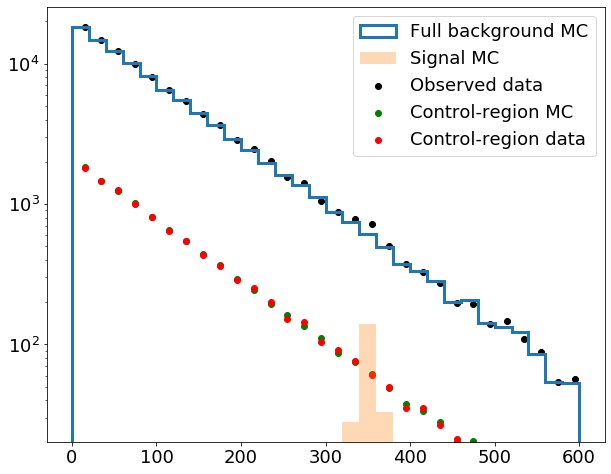

In [22]:
n_bins = 30
max_bin = 600
min_bin = 0

# Assuming this is Monte Carlo
plt.figure(figsize=(10,8))
background = np.random.exponential(100, round(1e5))
signal = np.random.normal(350,10, round(2e2))
bkg_count, _, _ = plt.hist(background, bins=n_bins, range=(min_bin, max_bin), histtype='step', linewidth=3, label='Full background MC')
sig_count, _, _ = plt.hist(signal, bins=n_bins, range=(min_bin, max_bin), histtype='stepfilled', alpha=0.3, label='Signal MC')

bin_center = np.arange(n_bins/2, max_bin, (max_bin-min_bin)/n_bins)

# Assuming this is data
background_with_noise = bkg_count + np.random.normal(0, np.sqrt(bkg_count)) 
signal_with_noise = sig_count + np.random.normal(0, np.sqrt(sig_count)) 
obs_data = background_with_noise + signal_with_noise
plt.scatter(bin_center, obs_data, color='black', label='Observed data')

# Assuming the control region is 10% data without signal presence
control_MC = 0.1 * bkg_count
control_region = 0.1 * background_with_noise + np.random.normal(0, np.sqrt(0.01*background_with_noise)) # data with some additional noise
plt.scatter(bin_center, control_MC, color='green', label='Control-region MC')
plt.scatter(bin_center, control_region, color='red', label='Control-region data')

plt.yscale('log')
plt.legend(loc='best')
plt.show()


### Test statistics $q_0$ for discovery of a positive signal



To discover new signal, we need to reject $\mu$ = 0 hypothesis. We have

$q_0 = 
-2\ln \lambda(0)$ for $\hat{\mu} \geq 0$ and zero for $\hat{\mu} < 0$, 

where $\lambda(0)$ is the profile likelihood ratio for $\mu$ = 0: 

$\lambda(\mu) = \frac{L(\mu,\hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$

In this case the $p$-value is computed as

$p_0 = \int_{q_{0,\textrm{obs}}}^{\infty} f(q_0 | 0) dq_0$

In a counting experiment, where one observes a number of events $n$, assumed to follow a Poisson distribution with an expectation value $E[n] = \mu s + b$, where $b$ is a nuissance parameter constrained by a control measurement, with expectation value $E[m] = \tau b$. 

$b$ is the expected MC in the signal region and $\tau$ is the transfer factor from the control to the signal region. Thus the data consist of two measured values: $n$ from signal region and $m$ from control region. The parameter of interest is $\mu$ and one nuissance parameter is $b$. The likelihood function for $\mu$ and $b$ is the product of two Poisson terms:

$ L(\mu, b) = \frac{(\mu s + b)^n}{n!}e^{-(\mu s + b)} \frac{(\tau b)^m}{m!} e^{-\tau b}
$

In our case, since we measure $b$ from 10% of the signal region, we take $\tau$ = 0.1 (or 1/9... depending on how observed data is obtained)

Maximum likelihood estimator returns:

$\hat{\mu} = \frac{n - m/\tau}{s} $

$\hat{b} = \frac{m}{\tau} $

$\hat{\hat{b}} = \frac{n+m-(1+\tau)\mu s}{2(1+\tau)} + \left[ \frac{(n+m - (1+\tau) \mu s)^2 + 4(1+\tau) m \mu s}{4(1+\tau)^2} \right]^{1/2}$


Now the test statistics becomes
- If $\hat{\mu} = \frac{n-m}{s} \geq 0$:  $q_0 = -2 \ln \lambda(0) = \frac{L(0, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$
- If $\hat{\mu} = \frac{n-m}{s} < 0$:  $q_0 = 0$

Let's start first with the counting experiment (because doing the fit for shape analysis takes more effort and often fails...)


In [23]:
# Defining necessary variables
eps = 1e-10

def get_likelihood(mu, b, s, tau, N, M):
    """
    mu, b: array of bins. b is the expected background
    N: observed data
    M: observed background
    tau: scale factor for background
    s = 0 for null hypothesis, 1 for alternative hypothesis
    
    Return: L(N, M | mu,b,s,tau)
    """
    average_signal = mu * s + b
    A = stats.poisson.pmf(average_signal.astype(np.int), N) 
    B = stats.poisson.pmf((tau*b).astype(np.int), M)
    likelihood = A * B
    likelihood = np.where(likelihood < 1e-15, np.full_like(likelihood, 1e-15), likelihood)
    
    return likelihood

def get_mu_hat(N, M, tau, s):
    return (N-M/tau)/(s+eps) 

def get_b_hat(M, tau):
    return M/tau

def get_b_doublehat(mu, b, s, tau, N, M):
    A = (N+M-(1+tau)*mu*s)/(2*(1+tau))
    B = np.sqrt(((N+M-(1+tau)*mu*s)**2 + 4*(1+tau)*M*mu*s)/(4*((1+tau)**2)))
    return A+B

def discovery_hypothesis_testing(bkg_count, sig_count, tau, M_obs, N_obs, N_asymov=round(1e5), show_plot=False):
    """
    bkg_count: Expected background from MC in control region, ie, 10% of data
    sig_count: Expected signal from MC
    M_obs: observed data from the control region
    N_obs: observed data from the signal region
    """
    # Get observed test statistics q_obs
    mu_hat = get_mu_hat(N=N_obs, M=M_obs, tau=tau, s=sig_count)
    b_hat = get_b_hat(M=M_obs, tau=tau)
    b_doublehat = get_b_doublehat(mu=0, b=bkg_count, s=sig_count, tau=tau, N=N_obs, M=M_obs)

    denominator = get_likelihood(mu=mu_hat, b=b_hat, s=sig_count, tau=tau, N=N_obs, M=M_obs)
    numerator = get_likelihood(mu=0, b=b_doublehat, s=sig_count, tau=tau, N=N_obs, M=M_obs)
    q_obs = -2*np.log(numerator/denominator)

    q_obs = np.where(mu_hat >= 0, q_obs, 0)
    q_obs = np.sum(q_obs, axis=-1)
    
    # Compute the Asimov dataset
    expected_data = bkg_count/tau 
    
    # Sample from expected MC
    obs_asymov = np.random.poisson(expected_data, (N_asymov, expected_data.shape[0])) 
    ctrl_asymov = np.random.poisson(bkg_count, (N_asymov, bkg_count.shape[0]))
    
    # Compute the necessary variables
    mu_hat = get_mu_hat(N=obs_asymov, M=ctrl_asymov, tau=tau, s=sig_count)
    b_hat = get_b_hat(M=ctrl_asymov, tau=tau)
    b_doublehat = get_b_doublehat(mu=0, b=bkg_count, s=sig_count, tau=tau, N=obs_asymov, M=ctrl_asymov)

    denominator = get_likelihood(mu=mu_hat, b=b_hat, s=sig_count, tau=tau, N=obs_asymov, M=ctrl_asymov)
    numerator = get_likelihood(mu=0, b=b_doublehat, s=sig_count, tau=tau, N=obs_asymov, M=ctrl_asymov)
    q_0 = -2*np.log(numerator/denominator)
    # Only take q_0 where mu_hat >= 0
    q_0 = np.where(mu_hat >= 0, q_0, 0)
    q_0 = np.sum(q_0, axis=-1)
    
    N_worse = np.sum(q_0 > q_obs)
    
    if show_plot:
        plt.figure(figsize=(10,8))
        binContent, _, _ = plt.hist(q_0, label='f($q_0$|0)', bins=40)
        plt.plot([q_obs, q_obs], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.yscale('log')
        plt.ylabel('Entries')
    
    pval = max(1., N_worse)/float(N_asymov)
    print("Observed test statistics: {}".format(q_obs))
    print("p-value: {}".format(pval))
    return pval


Observed test statistics: -5.430269618501559
p-value: 7e-05


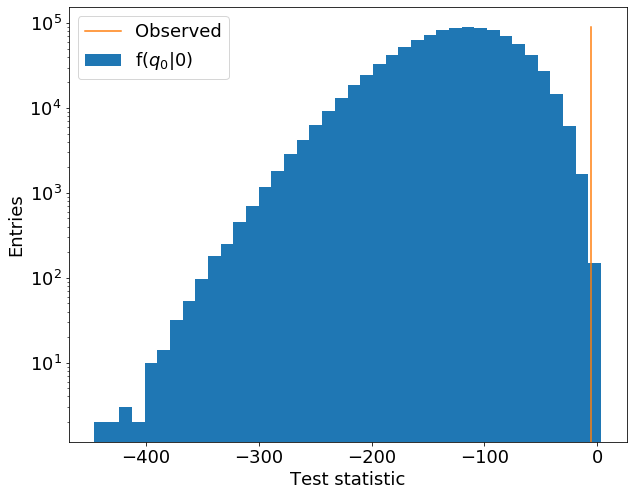

In [24]:
pval = discovery_hypothesis_testing(bkg_count=control_MC, sig_count=sig_count, 
                                    tau=0.1, M_obs=control_region, N_obs=obs_data, N_asymov=round(1e6), show_plot=True)

Obviously this counting experiment method only work when the expected signal in each bin is non-zero. In this toy example I put an artificial epsilon = 1e-10 for the expected signal in non-signal bins. 

To do it correctly and make Maurizio happy, we need to do the fit for the shape analysis. To be updated...